# If max_len_text > 1000 or latent_dim > 50, my computer crashes. Increasing these to 4000 and 300 would likely give better results, although it's not very promising

In [1]:
import numpy as np  
import pandas as pd 
import re           
import os
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import nltk

Using TensorFlow backend.


In [2]:
# Data prepared in ../Prepare-AMI-corpus-data, 
# found in link https://github.com/gcunhase/AMICorpusXML/tree/master/data
data=pd.read_csv("..\\..\\Data\\model_training\\AMI.csv")
data[['Text','Summary']]

,Text,Summary
0,"Um I'm Craig and I'm User Interface. Yeah. Well, my favourite animal would be a monkey. Then they're small cute and furry, and uh when planet of the apes becomes real, I'm gonna be up there with t...",The project manager introduced the upcoming project to the team members and then the team members participated in an exercise in which they drew their favorite animal and discussed what they liked...
1,"Mm yeah. Nope, we're all set. Which which is the clunky one, the one on left or on the right?.. Okay. No. I'll add it later, I guess the presentation. No. No. Um function F_ eight. Function, the b...",The project manager briefed the team on some new requirements to consider when designing the remote. The user interface designer presented two existing products and discussed what was wrong with e...
2,"Yeah. Yeah, sure. It kinda does make sense, doesn't it, because when we get into the end of meeting we're kind of talking about action and design as opposed to background. Everything I have is kin...","The project manager recapped the decisions made in the previous meeting. The marketing expert discussed his findings from trend watching reports, stressing the need for a product that has a fancy ..."
3,"No. Ninja Homer, made in Japan. And there isn't uh d it doesn't open up to the advanced functions? So the advanced functions are still hidden from you, but they're hidden in the sense that um they...",The project manager recapped the decisions made in the previous meeting and two team members presented their prototype and discussed the features the prototype contained. The team then looked at t...
4,"Okay, well I think we're ready to begin. Right, my name's Adam Duguid, we're here because of real reaction, um, we have in the group Um, yeah, go for it mate. N_ E_ Z_. Ebenezer. And your role is?...",The team members introduced themselves to each other by name and by their roles in the project. The project manager introduced the upcoming project to the team and then the team members participat...
...,...,...
137,"Okay. Could could I see the scroll bar as uh as as a sort of shortcut? A a and the voice recognition as well, th maybe you could uh could uh Yeah. Okay. Okay, good. And and the case is is rubber? ...","The UI and ID presented a prototype drawing of the remote control design. It can be used as a normal remote, but the speech recognition also provides a more advanced alternative interface. The spe..."
138,"Okay, good morning. This is our first team meeting. I'll be your Project Manager for today, for this project. My name is Mark will be giving this presentation for you to kick the project off. That...","The goal of the project is to design an original, trendy and user-friendly remote control for TV. The team comprises the project manager, the marketing expert, who is looking at user needs, the us..."
139,"Okay, we Mm. Okay, that's fine. Um. Okay, now work a little with me. Okay. Well, let's start it as it is. Okay, uh the method. There are a few questions that need to be answered, uh you already uh...",Customers are willing to pay more for fancier looking remotes. They like innovative technology like speech recognition and LCD screens. It also transpires that remotes are easy to lose. Everyone a...
140,"Hello. So, are you d what were j you guys discussing? Okay. Did you find anything new? Mm-hmm. Great, great. Come on.. What's uh here. And there we are. What the f oh, yeah uh. It doesn't do what ...","For the conceptual design, the ID suggested to use kinetic dynamo as energy source. The decision veered towards the basic battery option with no recharging station. They also decided to go for a s..."


In [3]:
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)
data[['Text','Summary']]

,Text,Summary
0,"Um I'm Craig and I'm User Interface. Yeah. Well, my favourite animal would be a monkey. Then they're small cute and furry, and uh when planet of the apes becomes real, I'm gonna be up there with t...",The project manager introduced the upcoming project to the team members and then the team members participated in an exercise in which they drew their favorite animal and discussed what they liked...
1,"Mm yeah. Nope, we're all set. Which which is the clunky one, the one on left or on the right?.. Okay. No. I'll add it later, I guess the presentation. No. No. Um function F_ eight. Function, the b...",The project manager briefed the team on some new requirements to consider when designing the remote. The user interface designer presented two existing products and discussed what was wrong with e...
2,"Yeah. Yeah, sure. It kinda does make sense, doesn't it, because when we get into the end of meeting we're kind of talking about action and design as opposed to background. Everything I have is kin...","The project manager recapped the decisions made in the previous meeting. The marketing expert discussed his findings from trend watching reports, stressing the need for a product that has a fancy ..."
3,"No. Ninja Homer, made in Japan. And there isn't uh d it doesn't open up to the advanced functions? So the advanced functions are still hidden from you, but they're hidden in the sense that um they...",The project manager recapped the decisions made in the previous meeting and two team members presented their prototype and discussed the features the prototype contained. The team then looked at t...
4,"Okay, well I think we're ready to begin. Right, my name's Adam Duguid, we're here because of real reaction, um, we have in the group Um, yeah, go for it mate. N_ E_ Z_. Ebenezer. And your role is?...",The team members introduced themselves to each other by name and by their roles in the project. The project manager introduced the upcoming project to the team and then the team members participat...
...,...,...
137,"Okay. Could could I see the scroll bar as uh as as a sort of shortcut? A a and the voice recognition as well, th maybe you could uh could uh Yeah. Okay. Okay, good. And and the case is is rubber? ...","The UI and ID presented a prototype drawing of the remote control design. It can be used as a normal remote, but the speech recognition also provides a more advanced alternative interface. The spe..."
138,"Okay, good morning. This is our first team meeting. I'll be your Project Manager for today, for this project. My name is Mark will be giving this presentation for you to kick the project off. That...","The goal of the project is to design an original, trendy and user-friendly remote control for TV. The team comprises the project manager, the marketing expert, who is looking at user needs, the us..."
139,"Okay, we Mm. Okay, that's fine. Um. Okay, now work a little with me. Okay. Well, let's start it as it is. Okay, uh the method. There are a few questions that need to be answered, uh you already uh...",Customers are willing to pay more for fancier looking remotes. They like innovative technology like speech recognition and LCD screens. It also transpires that remotes are easy to lose. Everyone a...
140,"Hello. So, are you d what were j you guys discussing? Okay. Did you find anything new? Mm-hmm. Great, great. Come on.. What's uh here. And there we are. What the f oh, yeah uh. It doesn't do what ...","For the conceptual design, the ID suggested to use kinetic dynamo as energy source. The decision veered towards the basic battery option with no recharging station. They also decided to go for a s..."


In [4]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, exclude_encodings="lxml").text # removes html/xml taggs
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\R-k-l\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [7]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [8]:
for i in range(1):
    print("Review:",data['cleaned_text'][i])
    print("Summary:",data['cleaned_summary'][i])
    print("\n")

Review: craig user interface yeah well favourite animal would monkey small cute furry planet apes becomes real gonna yeah know parents went bought remote controls got fed four five different remote controls things house many devices control hmm great andrew marketing expert hmm hmm yeah yeah fine alright one right okay nice alright favourite animal like beagle charac favourite characteristics right right well basically high priority animal willing take lot physical affection family yeah lots personality fit robust good health blue blue beagle family beagle coulda told whole lot beagles boy let tell impressionist alright superb sketch way yep see dog yep see rooster kind aware cha tail chasing hmm probably little got lots attention forever conditioned kay bas twel alright yeah okay cost like production cost twelve fifty selling price wholesale retail like shelf sale sale anyway yeah okay okay okay hmm alright yes hmm hmm well right away wondering like players zones frequencies something

In [9]:
import matplotlib.pyplot as plt
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 30)
plt.show()
plt.show()

<Figure size 640x480 with 2 Axes>

In [10]:
max_len_text=1000
max_len_summary=200
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True)

In [11]:

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1
x_voc_size

9398

In [12]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1
y_voc_size

1814

In [13]:
# # GLOVE_DIR = path for glove.6B.100d.txt
# def glove_dictionary(GLOVE_DIR, glove_dimension):
#     embeddings_index = {}
#     f = open(os.path.join(GLOVE_DIR, 'glove.6B.'+str(glove_dimension)+'d.txt'))
#     for line in f:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         embeddings_index[word] = coefs
#     f.close()
#     return embeddings_index

In [14]:
# GLOVE_DIR='..\\Data\\word_embeddings'
# glove_dimension=200
# embeddings_index = glove_dictionary(GLOVE_DIR=GLOVE_DIR, glove_dimension=glove_dimension)
# print('Found %s word vectors.' % len(embeddings_index))

In [15]:
glove_dir='..\\..\\Data\\word_embeddings'
glove_dimension=200
embeddings_index = {}
with open(os.path.join(glove_dir, 'glove.6B.'+str(glove_dimension)+'d.txt'), encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [16]:
# from load_glove_embeddings import load_glove_embeddings # local function from .py file
# glove_dimension = 100
# import time
# timer_start = time.time()
# # word2index, embedding_matrix = load_glove_embeddings('Data/word_embeddings/glove.6B.'+str(glove_dimension)+'d.txt', embedding_dim=glove_dimension, include_empty_char=False)
# word2index, embedding_matrix = load_glove_embeddings('../Data/word_embeddings/glove.6B.'+str(glove_dimension)+'d.txt', embedding_dim=glove_dimension, include_empty_char=False)
# del embedding_matrix
# print('Found %s word vectors.' % len(word2index))
# print("Creating embeddings_index took", round(time.time() - timer_start, 1), "seconds.")
# del timer_start
# embeddings_index=word2index
# del word2index

In [17]:
from itertools import islice
list(islice(embeddings_index.items(), 1))

[('the',
  array([-7.1549e-02,  9.3459e-02,  2.3738e-02, -9.0339e-02,  5.6123e-02,
          3.2547e-01, -3.9796e-01, -9.2139e-02,  6.1181e-02, -1.8950e-01,
          1.3061e-01,  1.4349e-01,  1.1479e-02,  3.8158e-01,  5.4030e-01,
         -1.4088e-01,  2.4315e-01,  2.3036e-01, -5.5339e-01,  4.8154e-02,
          4.5662e-01,  3.2338e+00,  2.0199e-02,  4.9019e-02, -1.4132e-02,
          7.6017e-02, -1.1527e-01,  2.0060e-01, -7.7657e-02,  2.4328e-01,
          1.6368e-01, -3.4118e-01, -6.6070e-02,  1.0152e-01,  3.8232e-02,
         -1.7668e-01, -8.8153e-01, -3.3895e-01, -3.5481e-02, -5.5095e-01,
         -1.6899e-02, -4.3982e-01,  3.9004e-02,  4.0447e-01, -2.5880e-01,
          6.4594e-01,  2.6641e-01,  2.8009e-01, -2.4625e-02,  6.3302e-01,
         -3.1700e-01,  1.0271e-01,  3.0886e-01,  9.7792e-02, -3.8227e-01,
          8.6552e-02,  4.7075e-02,  2.3511e-01, -3.2127e-01, -2.8538e-01,
          1.6670e-01, -4.9707e-03, -6.2714e-01, -2.4904e-01,  2.9713e-01,
          1.4379e-01, -1.2325

In [18]:
word_index = x_tokenizer.word_index
local_embedding_matrix = np.zeros((len(word_index) + 1, glove_dimension))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        local_embedding_matrix[i] = embedding_vector
local_embedding_matrix.shape

(9398, 200)

In [19]:
local_embedding_matrix[:1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1000, 200)    1879600     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 1000, 50), ( 50200       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

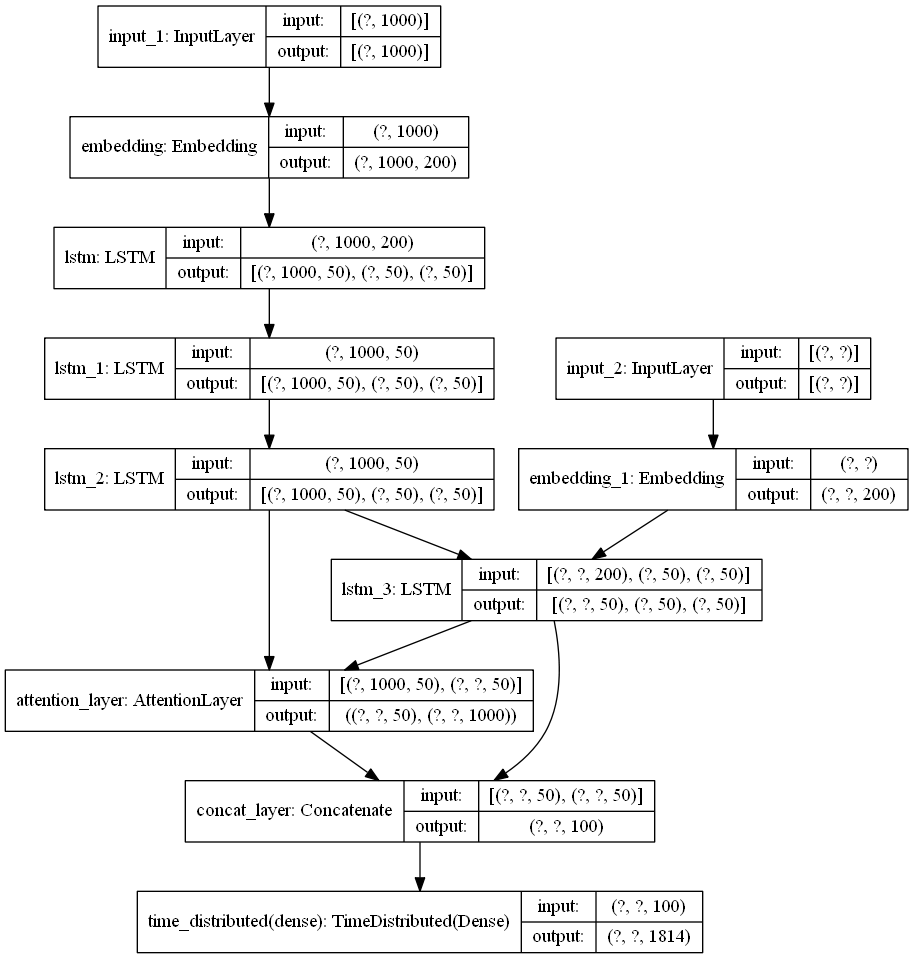

In [20]:
from attention import AttentionLayer
from keras import backend as K
K.clear_session()
latent_dim = 50

# Encoder 
encoder_inputs = Input(shape=(max_len_text,))
enc_emb = Embedding(x_voc_size, glove_dimension, 
                    weights=[local_embedding_matrix],input_length=max_len_text, trainable=False)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(x_voc_size, glove_dimension, 
                          weights=[local_embedding_matrix],input_length=max_len_text, trainable=False) 

dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()
# plot the model
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
import tensorflow as tf
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [21]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history=model.fit([x_tr,y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                  epochs=20,
                  callbacks=[es],
                  batch_size=16,
                  validation_data=([x_val,y_val[:,:-1]],
                  y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 127 samples, validate on 15 samples
Epoch 1/20
127/127 [==============================] - 49s 385ms/sample - loss: 6.9821 - val_loss: 6.0184
Epoch 2/20
127/127 [==============================] - 35s 278ms/sample - loss: 5.6910 - val_loss: 5.1736
Epoch 3/20
127/127 [==============================] - 36s 285ms/sample - loss: 5.1687 - val_loss: 4.8461
Epoch 4/20
127/127 [==============================] - 43s 338ms/sample - loss: 4.9779 - val_loss: 4.6980
Epoch 5/20
127/127 [==============================] - 43s 339ms/sample - loss: 4.9044 - val_loss: 4.6403
Epoch 6/20
127/127 [==============================] - 44s 347ms/sample - loss: 4.8629 - val_loss: 4.5880
Epoch 7/20
127/127 [==============================] - 45s 352ms/sample - loss: 4.8072 - val_loss: 4.5069
Epoch 8/20
127/127 [==============================] - 46s 360ms/sample - loss: 4.7341 - val_loss: 4.4296
Epoch 9/20
127/127 [==============================] - 46s 359ms/sample - loss: 4.6641 - val_loss: 4.3535
Epoch 10/2

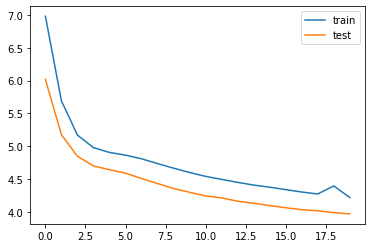

In [22]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [23]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

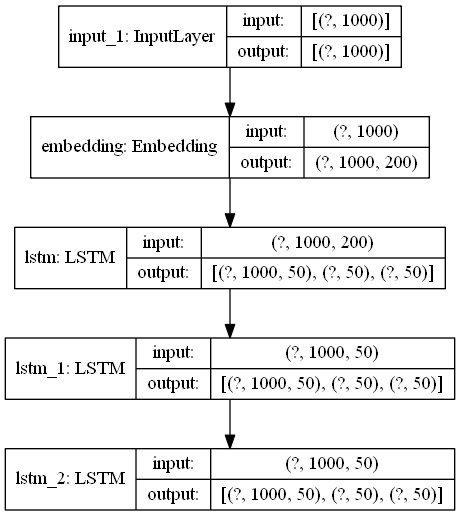

In [24]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
tf.keras.utils.plot_model(encoder_model, to_file='model.png', show_shapes=True)


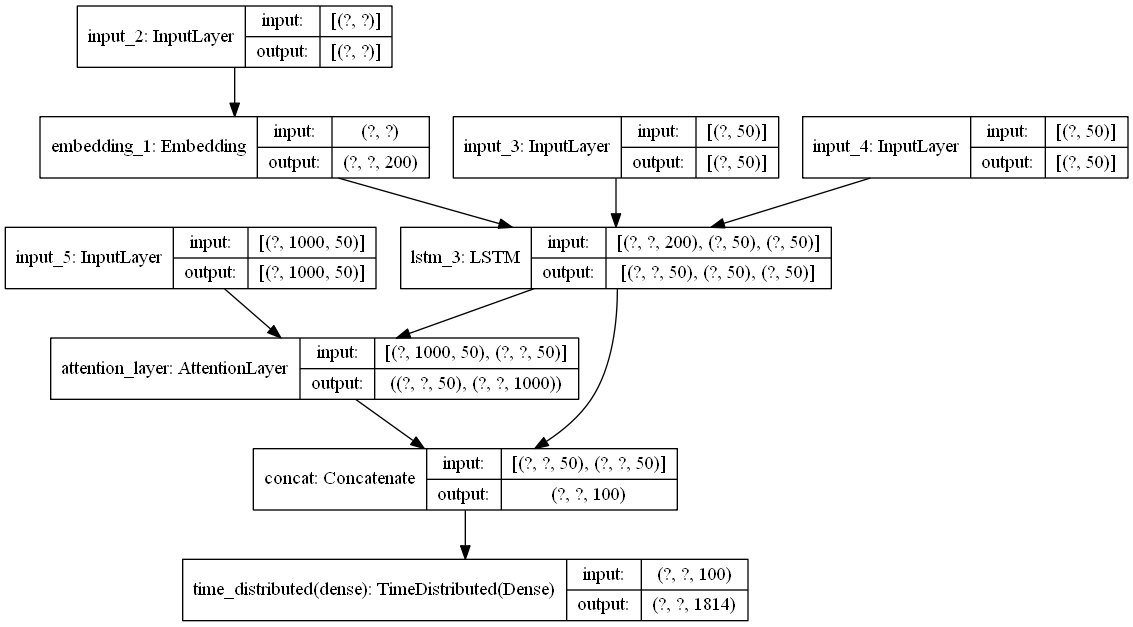

In [25]:
# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])
tf.keras.utils.plot_model(decoder_model, to_file='model.png', show_shapes=True)

In [26]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # print('input_seq: {}, e_out: {} '.format(input_seq,e_out))
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        # print("sampled_token:",sampled_token)
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # stop_condition = True
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [27]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [28]:
for i in range(10):
  print("Review:",seq2text(x_val[i]))
  print("Original summary:",seq2summary(y_val[i]))
  print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
  print("\n")

Review: things like screen settings audio settings would generally actual television like know little flap little control panel actual box would know using remote control would say definitely less relevant yes come sort decision functions though alright well fine sorry actually yellow black use website okay oops think talked individual roles well okay big loop table could ask figures come market research hmm wondering target price compares typical price things expect industrial designer know aiming build thing twelve euros fifty lot little surely wrong age group must one small population want slide show mode little button like sets one one left left bit left bit one yep press click wanna cheers actually got display screen still without okay wanna bring earth afraid talk actual practicalities thing needs work methodology used preparing meeting basically little bit web based research design team would discussing ideas net result come first cut working design would like discuss let back b

Predicted summary:  the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the proj

Predicted summary:  the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the proj

Predicted summary:  the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the proj

Predicted summary:  the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the proj

Predicted summary:  the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the proj

Predicted summary:  the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the proj

Predicted summary:  the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the proj

Predicted summary:  the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the project the proj